In [1]:
import numpy as np
import pylab as pl
%matplotlib inline

#Periodic and quasi periodic kernels

##Periodic (sine squared) kernel

This kernel is defined as
$k_{\mathrm{Per}}(t,t') = \exp \left[ - \Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) \right]$,
where $\Delta t = t-t'$, $\Gamma$ is the scale of the correlations and $P$ is the period. Let us take a look at the covariance function for various values of $\Gamma$.

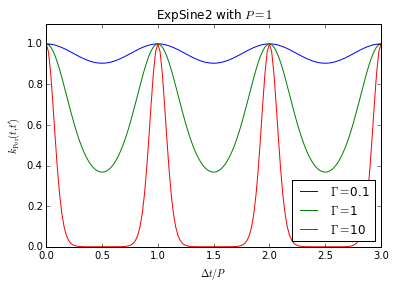

In [2]:
dt = np.r_[0:5:251j]
def expsine2(Gamma, P, dt):
    return np.exp(-Gamma*(np.sin(np.pi*dt/P))**2)
for Gamma in [0.1,1,10]:
    pl.plot(dt,expsine2(Gamma,1,dt), label = r"$\Gamma=$%s" % repr(Gamma))
pl.legend(loc='lower right')
pl.title(r"ExpSine2 with $P=1$")
pl.xlabel(r"$\Delta t/P$")
pl.ylabel(r"$k_{\mathrm{Per}}(t,t')$")
pl.xlim(0,3)
pl.ylim(0,1.1);

This clearly gives rise to strictly periodic functions with period $P$, as the covariance is 1 for $\Delta t = nP$. However, it would be nice to be able to relate the amplitude and length scale of the variations within a period to something more familiar. Let us compare the covariance function to the well known squared exponential kernel, defined as $k_{\mathrm{SE}}(t,t') = \exp \left[ - \frac{(\Delta t)^2}{2l^2} \right]$. 

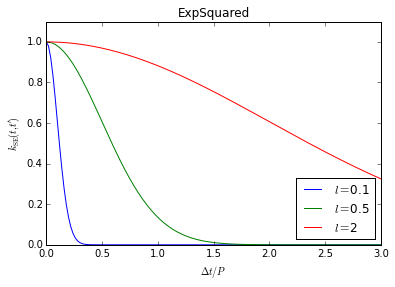

In [3]:
def expsquared(l, dt):
    return np.exp(-(dt/l)**2/2)
for l in [0.1,0.5,2]:
    pl.plot(dt,expsquared(l,dt), label = r"$l=$%s" % repr(l))
pl.legend(loc='lower right')
pl.title(r"ExpSquared")
pl.xlabel(r"$\Delta t/P$")
pl.ylabel(r"$k_{\mathrm{SE}}(t,t')$")
pl.xlim(0,3)
pl.ylim(0,1.1);

In the squared exponential kernel, the covariance ranges from 1 to 0 and falls to $e^{-0.5}$ when $\Delta t=l$. The range sets the variance of the variations and $l$ their length scale. How the lenght scale relates to the number of turning points per unit time is something I'll want to investigate later.

In the periodic kernel we're considering, the covariance ranges from 1 to $e^{-\Gamma}$. The variance of the variations therefore scales as $1-e^{-\Gamma}$. 

The covariance falls to $e^{-0.5\Gamma}$ times its full range when $\Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) = 0.5 \left( 1-e^{-\Gamma} \right)$, i.e. $\frac{\Delta t}{P} = \frac{1}{\pi} \arcsin\left( \sqrt{\frac{1-e^{-\Gamma}}{2\Gamma}}\right)$. This gives an estimate of the length scale of the variations within a period. </s></font>

NB1: For small $\Gamma$, the covariance never approaches zero, and this leads to functions which have non-zero mean, even over an infinite interval. Something similar happens with the squared exponential kernel for large $l$, but over a finite time interval $\Delta t \sim < l$.

NB2: for very small $\Gamma$, the variations look close to sinusoidal with period $P$.

Let's see if all this holds out in practice, by drawing samples from periodic and squared exponential GP priors with the appropriate parameters.

In [4]:
from george import GP, kernels
import time
def compare_per_se(P, Gamma, dt):
    gp_per = GP(kernels.ExpSine2Kernel(Gamma,P))
    gp_per.compute(dt,yerr=1e-3)
    seed = int(time.time())
    np.random.seed(seed)
    sam_per = gp_per.sample(dt,size=1)
    pl.plot(dt,sam_per.T,'k-', label = 'Per')
    pl.title(r"$P=$%s, $\Gamma=%s$" % (repr(P), repr(Gamma)))
    pl.xlabel(r"$t$")
    pl.ylabel(r"$f$")
    a_effective = np.sqrt(1 - np.exp(-Gamma))
    l_effective = (P/np.pi) * np.arcsin(np.sqrt((a_effective**2/2/Gamma)))
    print "amplitude=%.3f, length scale=%.3f" % (a_effective, l_effective)
    gp_se = GP(a_effective**2 * kernels.ExpSquaredKernel(l_effective**2))
    gp_se.compute(dt,yerr=1e-3)
    np.random.seed(seed)
    sam_se = gp_se.sample(dt,size=1)
    pl.plot(dt,sam_se.T,'k--', label = 'SE')
    pl.legend(loc=0)

amplitude=1.000, length scale=0.072


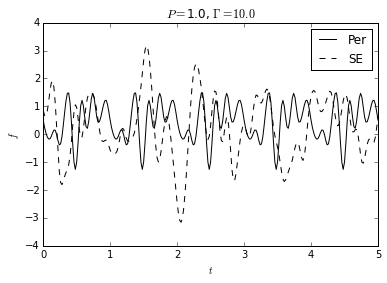

In [5]:
compare_per_se(1.0,10.0,dt)

amplitude=0.308, length scale=0.242


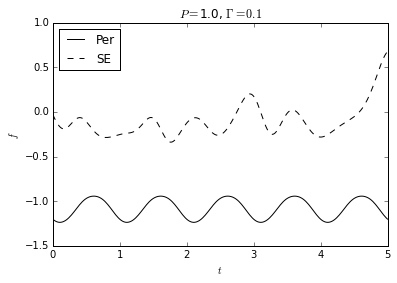

In [6]:
compare_per_se(1.0,0.1,dt)

amplitude=0.795, length scale=0.190


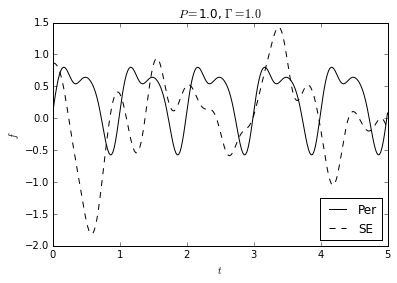

In [7]:
compare_per_se(1.0,1.0,dt)

This seems to give reasonable results for a wide range of $\Gamma$: the solid and dashed lines have similar amplitudes and length scales. Good!

## Quasi-periodic kernel

We can construct a quasi-periodic kernel by multiplying the periodic (ExpSine2) kernel by a squared exponential (or any other kernel, but let's stick to squared exponential for now). This is defined as:
$k_{\mathrm{QP}}(t,t') = \exp \left[ - \Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) - \frac{(\Delta t)^2}{2L^2}\right]$. Let us take a look at the covariance function.

solid: Gamma=0.5, dashed: Gamma=5
blue: L=0.3, green: L=3, red: L=30


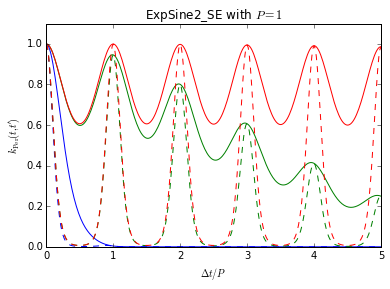

In [8]:
def expsine2_SE(Gamma, P, L, dt):
    return np.exp(-Gamma*(np.sin(np.pi*dt/P))**2 - dt**2/(2*L**2))
dt = np.r_[0:5:301j]
Gammas = [0.5,5]
Ls = [0.3,3,30]
lss = ['-', '--']
cols = ['b','g','r']
for i in range(len(Gammas)):
    Gamma = Gammas[i]
    ls = lss[i]
    for j in range(len(Ls)):
        L = Ls[j]
        col = cols[j]
        pl.plot(dt,expsine2_SE(Gamma,1,L,dt), \
                label = r"$\Gamma=$%s, $L=$%s" % (repr(Gamma), repr(L)), \
                ls = ls, c = col)
#pl.legend(loc='lower right')
pl.title(r"ExpSine2_SE with $P=1$")
pl.xlabel(r"$\Delta t/P$")
pl.ylabel(r"$k_{\mathrm{Per}}(t,t')$")
pl.xlim(0,5)
pl.ylim(0,1.1)
print "solid: Gamma=%s, dashed: Gamma=%s" % (Gammas[0], Gammas[1])
print "blue: L=%s, green: L=%s, red: L=%s" % (Ls[0], Ls[1], Ls[2])

For large $L$ (if $L \gg T$, where $T$ is the time span of the data), the behaviour is essentially the same as for the strictly periodic case. 

For small $L$ (if $L \ll P$), there are no subsidiary maxima, and the behaviour will look much like a squared exponential. However, if $\Gamma$ is small, it can still influence the length scale. <font color="red">_Probably need to double check this also_ <s> The covariance ranges for 0 to 1 but falls to $e^{-0.5}$ when $\Gamma \sin^2 \left(\frac{\pi \Delta t}{P} \right) + \frac{(\Delta t)^2}{2L^2}= 0.5$, i.e. when $(\Delta t)^2 = \frac{L^2 P^2}{2 \pi^2 L^2 \Gamma + P^2}$. In the extremes, the length scale can thus be approximated as $\Delta t \approx \frac{P}{\pi} \frac{1}{\sqrt{2\Gamma}}$ or $\Delta t \approx L$, whichever is the smaller.</s></font>

<font color=red>_This has an error in it too, started to correct it but need to follow through._
Now, what is the condition for there to be secondary maxima? Set $\frac{\partial}{\partial \Delta t} \left[ k_{\rm QP}(t,t') \right]=0$, this implies $\sin(2 \pi \Delta t / P) = - \frac{P^2 \Delta t}{\pi \Gamma L^2}$. <s>This always has a solution at $\Delta t = 0$, but at least two solutions for non-zero $\Delta t$ exist if $L^2 / \Gamma > 3 P / 4$. (I get this by requiring that $- \Gamma \Delta t / L^2$ be $>-1$ at the first minimum of the sinusoid, which occurs at $\Delta t = 3 P / 4$.) The first is a minimum and the second a maximum. </s></font>

<font color="red">_And probably will need to edit this too..._<s>If that condition is satisfied, then we genuinely have what we might call a quasi-periodic process. The number of subsidiary maxima is $n = \mathrm{floor} \left(\frac{1}{4} + \frac{L^2}{P \Gamma} \right)$. This is the maximum number of cycles for which the process "remembers" anything of what it was doing $n$ cycles ago (i.e. for which the covariance for $\Delta t = nP$ is larger than the covariance for $\Delta t = nP \pm \epsilon$).</s></font>

It is not, however, what we would normally think of as the overall evolutionary timescale of the process: that is given by the time interval for which the covariance has decayed by $e^{-0.5}$, which we can approximate as $L$. This approximation ignores the oscillatory component of the covarinace function and focuses on the exponential envelope only, but that's ok, because the evolutionary timescale is only constrained if the time span of the data is significantly longer than $L$, which is equivalent to saying that the periodic wobbles are small compared to the overall decay.

The approximation derived in the periodic case for the length scale of the variations within a cycle can still be used, though we should note that the smaller $L$ is, the worse an approximation it will be. 

Finally, provided $L^2 / \Gamma > 3 P / 4$ and the time span $T$ of the observations exceeds $P$ (i.e. there are subsidiary minima and maxima in the covariance function as evaluated over $\Delta t \le T$), the minimum of the covariance occurs at $\Delta t = (n-1/2)P$ where $n=\mathrm{floor}(T/P)$, at which point $k_{\rm QP} \approx \exp \left( - \Gamma - \frac{T^2}{2L^2} \right)$. So the variance of the functions this process generates, when evaluated over time span $T$, is approximately given by $1-\exp \left( - \Gamma - \frac{T^2}{2L^2} \right)$.

Next I should look at how well this bears out in practice. But I've run out fo time for today.

In [9]:
def compare_QP_se(P, Gamma, L, dt):
    gp_QP = GP(kernels.ExpSine2Kernel(Gamma,P) * kernels.ExpSquaredKernel(L**2))
    gp_QP.compute(dt,yerr=1e-3)
    seed = int(time.time())
    np.random.seed(seed)
    sam_QP = gp_QP.sample(dt,size=1)
    pl.plot(dt,sam_QP.T,'k-', label = 'Per')
    pl.title(r"$P=$%s, $\Gamma=%s$,$L=$%s" % (repr(P), repr(Gamma), repr(L)))
    pl.xlabel(r"$t$")
    pl.ylabel(r"$f$")
    if (L**2/Gamma) < (3*P/4):
        print 'No secondary covariance maxima: process is not periodic'
        l_effective = min(P/np.pi/np.sqrt(2*Gamma), L)
        a_effective = 1.0
        l_evol = np.nan
    else:
        l_evol = L
        a_effective = np.sqrt(1 - np.exp(-Gamma))
        l_effective = (P/np.pi) * np.arcsin(np.sqrt((a_effective**2/2/Gamma)))
    print "amplitude=%.3f, length scale=%.3f, evolutionary length scale %.1f" % (a_effective, l_effective, l_evol)
    gp_se = GP(a_effective**2 * kernels.ExpSquaredKernel(l_effective**2))
    gp_se.compute(dt,yerr=1e-3)
    np.random.seed(seed)
    sam_se = gp_se.sample(dt,size=1)
    pl.plot(dt,sam_se.T,'k--', label = 'SE')
    if np.isfinite(l_evol):
        gp_se2 = GP(a_effective**2 * kernels.ExpSquaredKernel(l_evol**2))
        gp_se2.compute(dt,yerr=1e-3)
        np.random.seed(seed)
        sam_se2 = gp_se2.sample(dt,size=1)
        pl.plot(dt,sam_se2.T,'k:', label = 'Evol')
    pl.legend(loc=0)

No secondary covariance maxima: process is not periodic
amplitude=1.000, length scale=0.300, evolutionary length scale nan


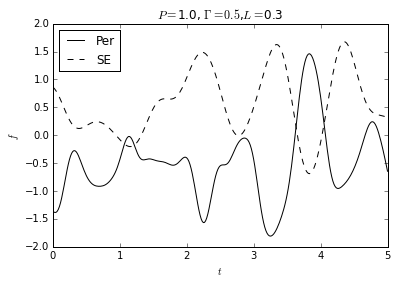

In [27]:
compare_QP_se(1.0, .5, .3, dt) # should be aperiodic with length scale ~ L

No secondary covariance maxima: process is not periodic
amplitude=1.000, length scale=0.101, evolutionary length scale nan


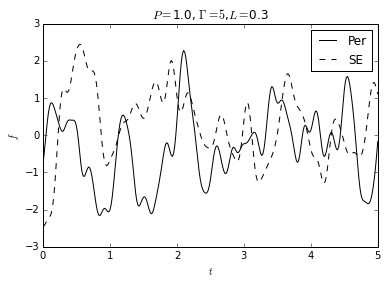

In [28]:
compare_QP_se(1.0, 5, .3, dt) # should be aperiodic with shorter length scale ~ 1/pi/sqrt(2Gamma)

amplitude=0.627, length scale=0.216, evolutionary length scale 3.0


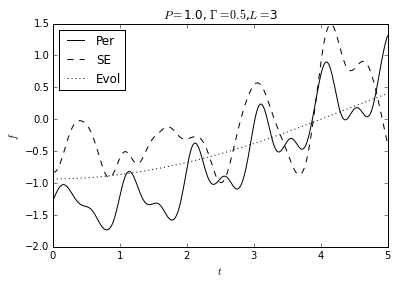

In [29]:
compare_QP_se(1.0, .5, 3, dt) 
# Should be periodic with evol timescale ~ L, total variance slightly < 1, 
# a few wiggles per period with smaller than overall variance

amplitude=0.997, length scale=0.102, evolutionary length scale 3.0


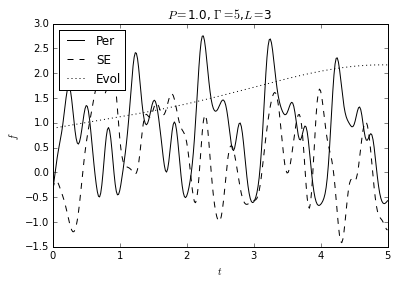

In [31]:
compare_QP_se(1.0, 5, 3, dt) 
# Should be periodic with evol timescale ~ L, total variance slightly ~ 1, 
# many wiggles per period with bigger variance

amplitude=0.627, length scale=0.216, evolutionary length scale 10.0


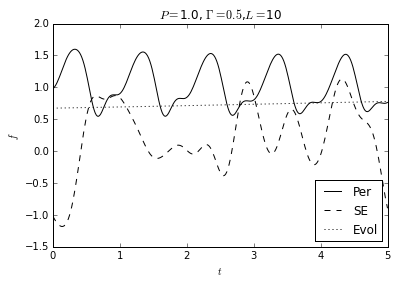

In [32]:
compare_QP_se(1.0, .5, 10, dt) 

amplitude=0.997, length scale=0.102, evolutionary length scale 10.0


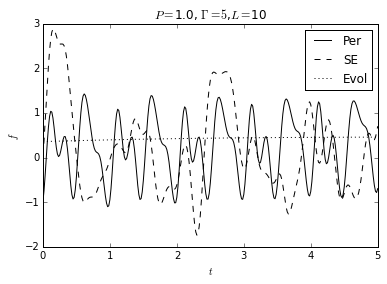

In [33]:
compare_QP_se(1.0, 5, 10, dt) 

All seems to behave as expected... Pfew!

This is encouraging because it means we have a way of relating the parameters of the QP GP kernel as defined above to properties of the time series that are themselves closely related to physical things we might be tryin to model like the lifetime and longitudinal distribution of active regions on a star.

## Lengthscale and turning points

I still need to work out the relationship between the length scale and number of turning points per unit time. Let's do this empirically, starting with a squared exponential process.

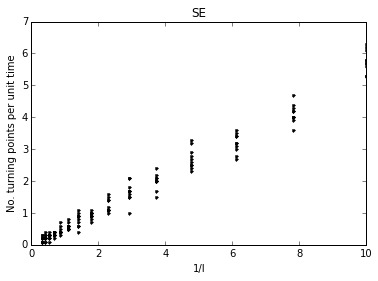

In [34]:
dt = np.r_[0:10:501j]
T = dt[-1]-dt[0]
logl = np.r_[-1:0.5:15j]
l = 10.0**logl
n = len(l)
nsim = 10
ntp = np.zeros((n,nsim))
def turningpoints(lst):
    dx = np.diff(lst)
    return (dx[1:] * dx[:-1] < 0)
for i in range(n):
    gp_se = GP(kernels.ExpSquaredKernel(l[i]**2))
    gp_se.compute(dt,yerr=1e-3)
    for j in range(nsim):
        sam_se = gp_se.sample(dt).flatten()
        tp = turningpoints(sam_se)
        ntp[i,j] = tp.sum()/float(T)
for i in range(n):
    pl.plot(np.ones(nsim)/l[i], ntp[i,:].flatten(), 'k.')
pl.title('SE')
pl.xlabel(r"1/l")
pl.ylabel('No. turning points per unit time')

It looks like the number of turning points per unit time approximately corresponds to $1/2l$. I wonder if there is a mathematical way of showing that.